# Deep Learning Course - Exercise 2

* Alon Mizrahi 312284706
* Nimrod Curtis 311230924

-------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------

### Import

In [1]:
## To import google drive, write this code in code section of colab and run it
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle
import sys
import timeit
import os
from IPython.display import Image

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

### Globals

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(f'Device: {device}')

Device: cuda


### Utils

In [17]:
def load_model_and_test(data_path, PATH, name, rnn_type):
  # parameters:
  batch_size = 20
  seq_length = 20
  hidden_size = 200
  layer_num = 2
  winit = 0.1
  total_epochs = 3
  factor_epoch = 4
  learning_rate = 1
  factor = 2
  max_grad_norm = 5
  dropout = 0
  rnn_type = rnn_type

  # data
  trn, vld, tst, vocab_size, words, dic_c2i  = data_init(data_path)
  trn = minibatch(trn, batch_size, seq_length)
  vld = minibatch(vld, batch_size, seq_length)
  tst = minibatch(tst, batch_size, seq_length)

  # init and load model 
  model = Model(vocab_size, hidden_size, layer_num, dropout, winit, rnn_type)
  model.to(device)
  model.load_state_dict(torch.load(PATH+name, map_location=device))
  model.eval()
  print(f"Test saved model of {name}...")
  # test model
  trn_perp = perplexity(trn, model, batch_size)
  val_perp = perplexity(vld, model, batch_size)
  tst_perp = perplexity(tst, model, batch_size)
  print("Final Result {} \nTrain set perplexity : {:.3f} || Validation set perplexity : {:.3f} || Test set perplexity : {:.3f}".format(name, trn_perp, val_perp, tst_perp))
  return model, dic_c2i, words

In [5]:
def plot_perp(train_perp, valid_perp, test_perp, name, save = False):

    epochs_idx = range(1, len(train_perp) + 1)
    # Plot the train and test accuracy 
    plt.plot(epochs_idx, train_perp, color='black', label='Training preplexity')
    plt.plot(epochs_idx, valid_perp, color='red', label='Validation preplexity')
    
    
    plt.xticks(range(0, len(train_perp) + 1, 5))
    plt.title(f'Preplexity convergence graph - {name}')
    plt.xlabel('Epochs')
    plt.ylabel('preplexity')
    plt.legend()
    
    print(f"Final results: \nTrain preplexity {train_perp[-1]:.2f} || Validation preplexity {valid_perp[-1]:.2f} || Test preplexity {test_perp[-1]:.2f}")
    
    if save:
      plt.savefig(f'/content/gdrive/MyDrive/Colab_Notebooks/Deep_Learning_Course/Exercises/EX_2_DL_RNN/312284706_311230924_ex2/plots/{name}.png')
    # Show the plot
    plt.show()

In [6]:
#The loss function.
def nll_loss(scores, y):
    batch_size = y.size(1)
    expscores = scores.exp()
    probabilities = expscores / expscores.sum(1, keepdim = True)
    answerprobs = probabilities[range(len(y.reshape(-1))), y.reshape(-1)]
    #I multiply by batch_size as in the original paper
    #Zaremba et al. sum the loss over batches but average these over time.
    return torch.mean(-torch.log(answerprobs) * batch_size)

def perplexity(data, model,batch_size):
    with torch.no_grad():
        losses = []
        states = model.state_init(batch_size)
        for x, y in data:
            scores, states = model(x, states)
            loss = nll_loss(scores, y)
            #Again with the sum/average implementation described in 'nll_loss'.
            losses.append(loss.data.item()/batch_size)
    return np.exp(np.mean(losses))

### Data

In [7]:
#Batches the data 
def minibatch(data, batch_size, seq_length):
    data = torch.tensor(data, dtype = torch.int64)
    num_batches = data.size(0)//batch_size
    data = data[:num_batches*batch_size]
    data=data.view(batch_size,-1)
    dataset = []
    for i in range(0,data.size(1)-1,seq_length):
        seqlen=int(np.min([seq_length,data.size(1)-1-i]))
        if seqlen<data.size(1)-1-i:
            x=data[:,i:i+seqlen].transpose(1, 0)
            y=data[:,i+1:i+seqlen+1].transpose(1, 0)
            dataset.append((x, y))
    return dataset

In [8]:
def data_init(data_path):
    data_train = os.path.join(data_path,'PTB/ptb.train.txt')
    data_valid = os.path.join(data_path,'PTB/ptb.valid.txt')
    data_test = os.path.join(data_path,'PTB/ptb.test.txt')
    with open(data_train) as f:
        file = f.read()
        trn = file[1:].split(' ')
    with open(data_valid) as f:
        file = f.read()
        vld = file[1:].split(' ')
    with open(data_test) as f:
        file = f.read()
        tst = file[1:].split(' ')
    words = sorted(set(trn))
    char2ind = {c: i for i, c in enumerate(words)}
    trn = [char2ind[c] for c in trn]
    vld = [char2ind[c] for c in vld]
    tst = [char2ind[c] for c in tst]
    return np.array(trn).reshape(-1, 1), np.array(vld).reshape(-1, 1), np.array(tst).reshape(-1, 1), len(words), words, char2ind

### Model - LSTM by Zaremba

In [9]:
#Embedding module.
class Embed(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.W = nn.Parameter(torch.Tensor(vocab_size, embed_size))

    def forward(self, x):
        return self.W[x]

    def __repr__(self):
        return "Embedding(vocab: {}, embedding: {})".format(self.vocab_size, self.embed_size)

class Linear(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.W = nn.Parameter(torch.Tensor(hidden_size, input_size))
        self.b = nn.Parameter(torch.Tensor(hidden_size))

    def forward(self, x):
        #.view() flattens the input which has dimensionality [T,B,X] to dimenstionality [T*B, X].
        z = torch.addmm(self.b, x.view(-1, x.size(2)), self.W.t())
        return z

    def __repr__(self):
        return "FC(input: {}, output: {})".format(self.input_size, self.hidden_size)

#The model as described in the paper.  
#Note that torch.nn implementation is faster. 
class Model(nn.Module):
    def __init__(self, vocab_size, hidden_size, layer_num, dropout, winit, rnn_type = "lstm"):
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.layer_num = layer_num
        self.winit = winit
        self.embed = Embed(vocab_size, hidden_size)
        self.rnn_type = rnn_type
        self.rnns = [nn.LSTM(hidden_size, hidden_size) if rnn_type == "lstm" else nn.GRU(hidden_size, hidden_size) for i in range(layer_num)]
        self.rnns = nn.ModuleList(self.rnns)
        self.fc = Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(p=dropout)
        self.reset_parameters()
        
    def reset_parameters(self):
        for param in self.parameters():
            nn.init.uniform_(param, -self.winit, self.winit)
            
    def state_init(self, batch_size):
        dev = next(self.parameters()).device
        if self.rnn_type == "lstm":
          states = [(torch.zeros(1, batch_size, layer.hidden_size, device = dev), torch.zeros(1, batch_size, layer.hidden_size, device = dev)) for layer in self.rnns]
        else: states = [(torch.zeros(1, batch_size, layer.hidden_size, device = dev)) for layer in self.rnns]
        return states
    
    def detach(self, states):
        if self.rnn_type == "lstm": return [(h.detach(), c.detach()) for (h,c) in states]
        else: return [(h.detach()) for (h) in states]
         
    def forward(self, x, states):
        x = self.embed(x)
        x = self.dropout(x)
        for i, rnn in enumerate(self.rnns):
            x, states[i] = rnn(x, states[i])
            x = self.dropout(x)
        scores = self.fc(x)
        return scores, states

### Train

In [10]:
def train(data, model, epochs, epoch_threshold, lr, factor, max_norm, batch_size):
    trn, vld, tst = data
    perp_trn_arr = []
    perp_vld_arr = []
    perp_tst_arr = []
    tic = timeit.default_timer()
    total_words = 0
    print("Starting training.\n")
    for epoch in range(epochs):
        states = model.state_init(batch_size)
        model.train()
        if epoch > epoch_threshold:
            lr = lr / factor
        for i, (x, y) in enumerate(trn):
            total_words += x.numel()
            model.zero_grad()
            states = model.detach(states)
            scores, states = model(x, states)
            loss = nll_loss(scores, y)
            loss.backward()
            with torch.no_grad():
                norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm)
                for param in model.parameters():
                    param -= lr * param.grad
            # if i % (len(trn)//5) == 0:
            #     toc = timeit.default_timer()
            #     print("batch no = {:d} / {:d}, ".format(i, len(trn)) +
            #           "train loss = {:.3f}, ".format(loss.item()/batch_size) +
            #           "wps = {:d}, ".format(round(total_words/(toc-tic))) +
            #           "dw.norm() = {:.3f}, ".format(norm) +
            #           "lr = {:.3f}, ".format(lr) +
            #           "since beginning = {:d} mins, ".format(round((toc-tic)/60)) + 
            #           "cuda memory = {:.3f} GBs".format(torch.cuda.max_memory_allocated()/1024/1024/1024))
        model.eval()
        trn_perp = perplexity(trn, model, batch_size)
        perp_trn_arr.append(trn_perp)
        val_perp = perplexity(vld, model, batch_size)
        perp_vld_arr.append(val_perp)
        print("Epoch : {:d} || Train set perplexity : {:.3f} || Validation set perplexity : {:.3f}".format(epoch+1, trn_perp, val_perp))
        print("***********************************************************************************")
    tst_perp = perplexity(tst, model, batch_size)
    perp_tst_arr.append(tst_perp)
    print("Test set perplexity : {:.3f}".format(tst_perp))
    print("Training is over.")

    return model, perp_trn_arr, perp_vld_arr, perp_tst_arr

### Main Function

Default parameters:
* layer_num 2 
* hidden_size 200 
* dropout 0.0 
* winit 0.1 
* batch_size 20 
* seq_length 20
* learning_rate 1 
* total_epochs 13 
* factor_epoch 4 
* factor 1.8 
* max_grad_norm 5

In [11]:
def main(data_path,rnn_type = "lstm", dp = 0.0):
  
  # parameters:
  rnn_type = rnn_type
  batch_size = 20
  seq_length = 20
  hidden_size = 200
  layer_num = 2
  winit = 0.1
  total_epochs = 25
  factor_epoch = 4
  learning_rate = 1 
  factor =  1.8 
  max_grad_norm = 5
  dropout = dp
  if rnn_type == "gru": learning_rate = 0.8
  if dropout != 0: factor =  1.2

  # data
  data_path = data_path
  trn, vld, tst, vocab_size, words, dic_c2i  = data_init(data_path)
  trn = minibatch(trn, batch_size, seq_length)
  vld = minibatch(vld, batch_size, seq_length)
  tst = minibatch(tst, batch_size, seq_length)

  # model
  model = Model(vocab_size, hidden_size, layer_num, dropout, winit, rnn_type)
  model.to(device)

  # train
  model, perp_trn_arr, perp_vld_arr, perp_tst_arr = train((trn, vld, tst), model, total_epochs, factor_epoch, learning_rate, factor, max_grad_norm, batch_size)

  return model, dic_c2i, words, perp_trn_arr, perp_vld_arr, perp_tst_arr

--------------------------------------------------------------------------
--------------------------------------------------------------------------


### For the Instructor
1. First set your relevant paths:
  - models dir
  - dataset dir
  - plots dir (optional if you would like to see convergence graphs we saved)

2. The choose to train/load model :
  - Load Trained Model and Test it (flag = 1)
  - Train new model (flag = 0)

3. Pick the method from:

  - 'LSTM_without_dropout' 
  - 'LSTM_with_dropout' 
  - 'GRU_without_dropout' 
  - 'GRU_with_dropout' 

  Then run the cell after, good luck! 

4. Finally examine the data and inference the model!

In [83]:
# # 1. 
# # path to model dir
# # TODO
PATH= '/content/gdrive/MyDrive/Colab_Notebooks/Deep_Learning_Course/Exercises/EX_2_DL_RNN/312284706_311230924_ex2/models/'
PATH= '/content/gdrive/MyDrive/Deep Learning Course/Exercises/EX_2_DL_RNN/312284706_311230924_ex2/models/'

# # path to data dir
# # TODO
PATH_to_data = '/content/gdrive/MyDrive/Colab_Notebooks/Deep_Learning_Course/Exercises/EX_2_DL_RNN/312284706_311230924_ex2/data/'
PATH_to_data = '/content/gdrive/MyDrive/Deep Learning Course/Exercises/EX_2_DL_RNN/312284706_311230924_ex2/data/'

# path to plots dir (optional)
PATH_to_our_images = '/content/gdrive/MyDrive/Colab_Notebooks/Deep_Learning_Course/Exercises/EX_2_DL_RNN/312284706_311230924_ex2/plots/'


# 2. 
# Train new model  -> flag = 0
# Load model -> flag = 1
flag = 1

# # 3.
name = 'GRU_with_dropout' #'LSTM_without_dropout' # 'LSTM_with_dropout' # 'GRU_without_dropout' # 'GRU_with_dropout'


In [84]:
if flag == 0:
  print(f"Start training of {name}...")
  if name == 'LSTM_without_dropout':
    model, dic_c2i, words, perp_trn_arr, perp_vld_arr, perp_tst_arr = main(data_path=PATH_to_data,rnn_type = "lstm", dp = 0.0)
    plot_perp(perp_trn_arr, perp_vld_arr, perp_tst_arr, name,  save = False)
  elif name == 'LSTM_with_dropout':
    model, dic_c2i, words, perp_trn_arr, perp_vld_arr, perp_tst_arr = main(data_path=PATH_to_data, rnn_type = "lstm", dp = 0.25)
    model, dic_c2i, words, perp_trn_arr, perp_vld_arr, perp_tst_arr = plot_perp(perp_trn_arr, perp_vld_arr, perp_tst_arr, name,  save = False)
  elif name == 'GRU_without_dropout':
    model, dic_c2i, words, perp_trn_arr, perp_vld_arr, perp_tst_arr = main(data_path=PATH_to_data, rnn_type = "gru", dp = 0.0)
    plot_perp(perp_trn_arr, perp_vld_arr, perp_tst_arr, name,  save = False)
  elif name == 'GRU_with_dropout':
    model, dic_c2i, words, perp_trn_arr, perp_vld_arr, perp_tst_arr = main(data_path=PATH_to_data, rnn_type = "gru", dp = 0.25)
    plot_perp(perp_trn_arr, perp_vld_arr, perp_tst_arr, name,  save = False)

elif flag == 1:
  if (name == 'LSTM_without_dropout' or name == 'LSTM_with_dropout'): rnn_type = "lstm"
  elif (name == 'GRU_without_dropout' or name == 'GRU_with_dropout'): rnn_type = "gru"
  model, dic_c2i, words = load_model_and_test(PATH_to_data, PATH, name, rnn_type)



Test saved model of GRU_with_dropout...
Final Result GRU_with_dropout 
Train set perplexity : 42.221 || Validation set perplexity : 101.532 || Test set perplexity : 97.452


### Our Runs

We executed the main function 4 times, 1 training for each method.

You can see the cells below with the commented code. 

Then you can show the plots we got after training the 4 models.

In [ ]:
# name = 'LSTM_without_dropout'
# rnn_type = "lstm"
# dp = 0.0
# model, dic_c2i, words, perp_trn_arr, perp_vld_arr, perp_tst_arr = main(rnn_type, dp)
# plot_perp(perp_trn_arr, perp_vld_arr, perp_tst_arr, name,  save = True)
# #save trained model
# torch.save(model.state_dict(), PATH+name)

In [ ]:
# name = 'LSTM_with_dropout'
# rnn_type = "lstm"
# dp = 0.25
# model, dic_c2i, words, perp_trn_arr, perp_vld_arr, perp_tst_arr = main(rnn_type, dp)
# plot_perp(perp_trn_arr, perp_vld_arr, perp_tst_arr, name,  save = True)
# #save trained model
# torch.save(model.state_dict(), PATH+name)

In [ ]:
# name = 'GRU_without_dropout'
# rnn_type = "gru"
# dp = 0.0
# model, dic_c2i, words, perp_trn_arr, perp_vld_arr, perp_tst_arr = main(rnn_type, dp)
# plot_perp(perp_trn_arr, perp_vld_arr, perp_tst_arr, name,  save = True)
# #save trained model
# torch.save(model.state_dict(), PATH+name)

In [ ]:
# name = 'GRU_with_dropout'
# rnn_type = "gru"
# dp = 0.25
# model, dic_c2i, words, perp_trn_arr, perp_vld_arr, perp_tst_arr = main(rnn_type, dp)
# plot_perp(perp_trn_arr, perp_vld_arr, perp_tst_arr, name,  save = True)
# #save trained model
# torch.save(model.state_dict(), PATH+name)

------------------------------------------------------------------------------------
----------------------------- LSTM_without_dropout ---------------------------------
------------------------------------------------------------------------------------


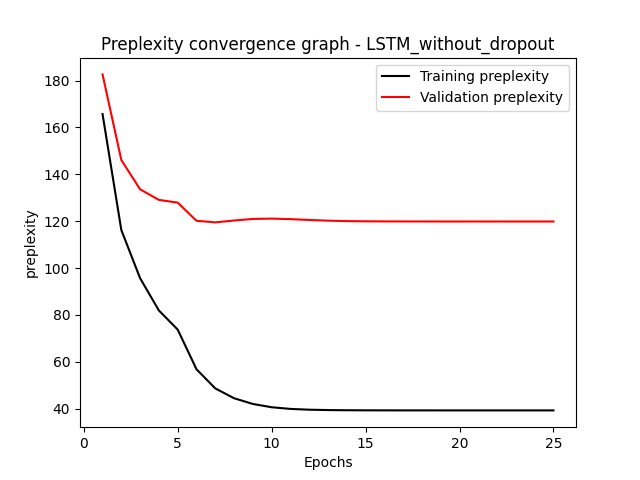

In [ ]:
print('------------------------------------------------------------------------------------')
print('----------------------------- LSTM_without_dropout ---------------------------------')
print('------------------------------------------------------------------------------------')
Image(filename = PATH_to_our_images+'LSTM_without_dropout.png')

------------------------------------------------------------------------------------
-------------------------------- LSTM_with_dropout ---------------------------------
------------------------------------------------------------------------------------


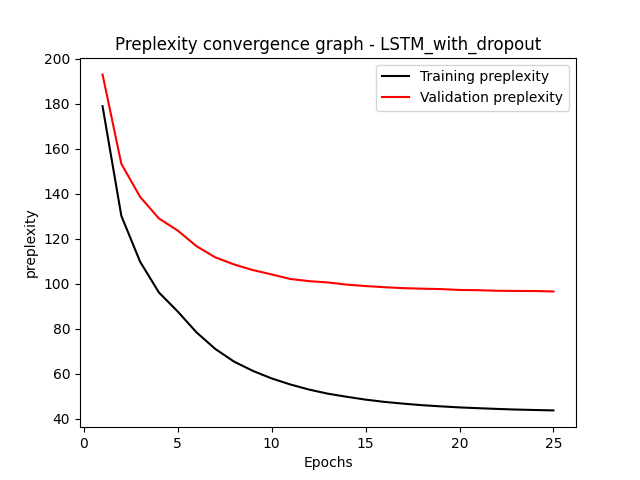

In [ ]:
print('------------------------------------------------------------------------------------')
print('-------------------------------- LSTM_with_dropout ---------------------------------')
print('------------------------------------------------------------------------------------')
Image(filename = PATH_to_our_images+'LSTM_with_dropout.png')

------------------------------------------------------------------------------------
---------------------------- GRU_without_dropout -----------------------------------
------------------------------------------------------------------------------------


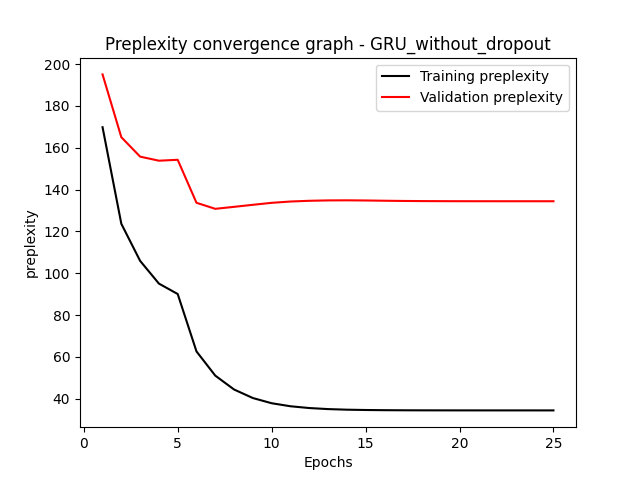

In [ ]:
print('------------------------------------------------------------------------------------')
print('---------------------------- GRU_without_dropout -----------------------------------')
print('------------------------------------------------------------------------------------')
Image(filename = PATH_to_our_images+'GRU_without_dropout.png')

------------------------------------------------------------------------------------
------------------------------- GRU_with_dropout -----------------------------------
------------------------------------------------------------------------------------


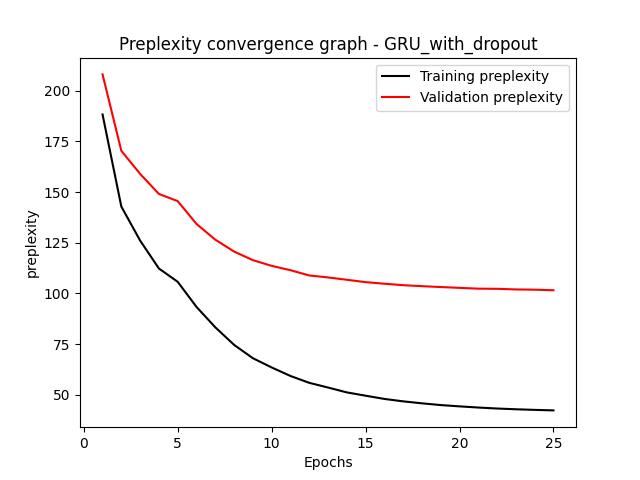

In [ ]:
print('------------------------------------------------------------------------------------')
print('------------------------------- GRU_with_dropout -----------------------------------')
print('------------------------------------------------------------------------------------')
Image(filename = PATH_to_our_images+'GRU_with_dropout.png')

## Data & Inference ##
In this section the data and the embed data is presented.

Then you can write an input sequence and get the next predicted output word from the model.

In [19]:
# data example embed
print(f"The word: '{words[100]}' is in index 100")
W = nn.Parameter(torch.Tensor(10000, 200))
print(f"The word as embeded from index 100 to tensor in size of 200: \n{W[100]}")

The word: 'accepted' is in index 100
The word as embeded from index 100 to tensor in size of 200: 
tensor([-0.2087,  1.3859,  0.2324, -0.1756,  1.6394, -1.1204, -0.2540,  0.4554,
         0.3208,  0.0677, -0.5166, -0.3606,  0.0144, -0.2860, -0.1002, -0.2336,
         0.1395,  0.5002, -0.3619, -0.7178,  0.1267,  0.1119, -0.2639,  0.3028,
         0.1898, -0.8367, -0.2048, -0.0518, -0.3095, -0.4954,  0.3730, -0.5046,
         0.1147, -0.4194, -0.1482, -0.4495, -1.1347, -0.6711, -0.0071,  0.4924,
         0.3094,  0.8632, -0.3839,  0.2065, -0.3448, -0.0602, -0.3465, -0.0398,
        -0.1634,  0.0808, -0.1311,  0.0515, -0.1837, -0.5958,  0.5511, -0.2539,
        -0.3168,  0.7335, -1.1232,  0.4898,  1.1182,  0.5156,  0.3483, -0.3731,
        -0.3438, -0.4522, -0.0158, -0.5621,  0.0489, -0.1865,  0.2861, -0.5606,
        -0.2781, -0.1371, -0.0325,  0.4682,  0.2438,  0.7020, -0.1319,  0.1816,
         0.6561, -0.0583,  0.3704,  0.6752, -0.5092, -1.7272,  0.1041,  0.7169,
        -1.0089,  0.5

In [78]:
# inference example
sq =" i think this is the end of" 
sq = sq[1:].split(' ')
len_sq = len(sq)
print(f"sequence splited: {sq}")
sq_to_model = [dic_c2i[c] for c in sq]
input_tensor = torch.LongTensor(sq_to_model).unsqueeze(0) # add batch dimension
print(f"input tensor of the sequence as an indexes from the sorted dict: {input_tensor}")


def get_key(my_dict,val):
    for key, value in my_dict.items():
        if val == value:
            return key
 
    return "key doesn't exist"

model.eval()
dev = next(model.parameters()).device
states = [(torch.zeros(1, len_sq, layer.hidden_size, device =dev ), torch.zeros(1, len_sq, layer.hidden_size, device =dev)) for layer in model.rnns]
with torch.no_grad():
    output, states = model(input_tensor, states)
pred_out_tensor = [torch.argmax(out).int().detach() for out in output]
print(f"output tensor: {pred_out_tensor}")
pred_next = [get_key(dic_c2i,pred_out_i) for pred_out_i in pred_out_tensor][-1]
print(f"predicted next word from the model: {pred_next}")

sequence splited: ['i', 'think', 'this', 'the', 'end', 'of']
input tensor of the sequence as an indexes from the sorted dict: tensor([[4385, 9042, 9048, 9012, 3058, 6142]])
output tensor: [tensor(9042, device='cuda:0', dtype=torch.int32), tensor(9012, device='cuda:0', dtype=torch.int32), tensor(9958, device='cuda:0', dtype=torch.int32), tensor(44, device='cuda:0', dtype=torch.int32), tensor(0, device='cuda:0', dtype=torch.int32), tensor(9012, device='cuda:0', dtype=torch.int32)]
predicted next word from the model: the
